In [8]:
import numpy as np
import tensorflow as tf
import os
import sys
import cv2
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input,Dropout,Conv2D,BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose,concatenate,MaxPooling2D,Activation,Flatten,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import regularizers
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from collections import Counter
from glob import glob
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from random import randrange

# Load Train and Validation Data

In [9]:
oTrainImgDir = "D:\PRS_project\Data_Set_HAM\segmentation_data_final\\train\\image\\"
oValImgDir = "D:\PRS_project\Data_Set_HAM\segmentation_data_final\\val\\image\\"
oTrainLblDir = "D:\PRS_project\Data_Set_HAM\segmentation_data_final\\train\\segmentation\\"
oValLblDir = "D:\PRS_project\Data_Set_HAM\segmentation_data_final\\val\\segmentation\\"

IMG_HEIGHT = 192
IMG_WIDTH = 256

class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, image_path, mask_path,
                 to_fit=True, batch_size=16, dim=(192, 256),
                 n_channels=3, n_classes=10, shuffle=True):
        """Initialization
        :param list_IDs: list of path to all images
        :param labels: list of path to all images
        :param image_path: path to images folder
        :param mask_path: path to masks folder
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.labels = labels
        self.image_path = image_path
        self.mask_path = mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)
        

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            for k in range(0,X.shape[0]):
                oAugIdx = randrange(4)
                if oAugIdx == 0:
                    X[k,],y[k,] =self._random_rotation(X[k], y[k])
                if oAugIdx == 1:
                    X[k,],y[k,] =self._horizontal_flip(X[k],y[k])
                if oAugIdx == 2:
                    X[k,],y[k,] =self._vertical_flip(X[k],y[k])
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self._load_image(self.image_path + ID+ ".jpg")

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            y[i,] = self._load_grayscale_image(self.mask_path + ID+ ".png")

        return y
    def _random_rotation(self,x_image, y_image):
        rows_x,cols_x, chl_x = x_image.shape
        rows_y,cols_y = y_image.shape
        rand_num = np.random.randint(-40,40)
        M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
        M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
        x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
        y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
        return x_image, y_image

    def _horizontal_flip(self,x_image, y_image):
        x_image = cv2.flip(x_image, 1)
        y_image = cv2.flip(y_image.astype('float32'), 1)
        return x_image, y_image
    def _vertical_flip(self,x_image, y_image):
        x_image = cv2.flip(x_image, 0)
        y_image = cv2.flip(y_image.astype('float32'), 0)
        return x_image, y_image
    
    def _load_image(self, image_path):
        img = cv2.imread(image_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img = img / 255.0
        return img
    def _load_grayscale_image(self, image_path):
        """Load grayscale image
        :param image_path: path to image to load
        :return: loaded image
        """
        img = cv2.imread(image_path,0)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #print(max(map(max, img)) )
        img = img / 255.0
        return img




def create_filename_list(oImgPath):
    oFile = []
    for path in oImgPath:
        oFileName = path.split("\\")[-1]
        oFileName = oFileName.split(".")[0]
        oFile.append(oFileName)
    return oFile    
#load train data 
oTrainImgPath = glob(oTrainImgDir + "*.jpg")
TrainFiles = create_filename_list(oTrainImgPath)

#load val data 
oValImgPath = glob(oValImgDir + "*.jpg")
ValFiles = create_filename_list(oValImgPath)


oTrainGen = DataGenerator(TrainFiles,TrainFiles,oTrainImgDir,oTrainLblDir)
oValGen = DataGenerator(ValFiles,ValFiles,oValImgDir,oValLblDir)


# Evaluation Matrix

In [10]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f =tf.compat.v1.layers.flatten(y_true)
    y_pred_f =tf.compat.v1.layers.flatten(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

In [11]:
def iou(y_true, y_pred, smooth = 100):
    intersection = tf.math.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    sum_ = tf.math.reduce_sum(tf.square(y_true), axis = -1) + tf.math.reduce_sum(tf.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [12]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.math.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    sum_ = tf.math.reduce_sum(tf.square(y_true), axis = -1) + tf.math.reduce_sum(tf.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

#  Network Hidden Layer

In [13]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    conv_final = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    outputs = Reshape((IMG_HEIGHT,IMG_WIDTH))(conv_final)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model



In [14]:
input_img = Input((IMG_HEIGHT,IMG_WIDTH, 3), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.3, batchnorm=True)
model.compile(optimizer=Adam(), loss=jaccard_distance, metrics=["accuracy",dice_coe,iou])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 192, 256, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 192, 256, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 192, 256, 32) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [15]:
callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-skin-lesion-segmentation.hdf5', verbose=1, save_best_only=True, save_weights_only=False)
]

# Network Training

In [16]:
results = model.fit(oTrainGen, batch_size=16, epochs=100, callbacks=callbacks,\
                    validation_data=oValGen,verbose=1)

Epoch 1/100


C:\Users\rggop\anaconda3\lib\site-packages\keras\legacy_tf_layers\core.py:513: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
C:\Users\rggop\anaconda3\lib\site-packages\keras\engine\base_layer.py:2215: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\rggop\anaconda3\lib\site-packages\keras\engine\base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


506/506 [==============================] - 209s 395ms/step - loss: 0.0876 - accuracy: 0.0733 - dice_coe: 0.7548 - iou: 0.9124 - val_loss: 0.0751 - val_accuracy: 0.2681 - val_dice_coe: 0.8121 - val_iou: 0.9249

Epoch 00001: val_loss improved from inf to 0.07514, saving model to model-skin-lesion-segmentation.hdf5
Epoch 2/100
506/506 [==============================] - 77s 152ms/step - loss: 0.0582 - accuracy: 0.0880 - dice_coe: 0.8323 - iou: 0.9418 - val_loss: 0.0594 - val_accuracy: 0.2019 - val_dice_coe: 0.8283 - val_iou: 0.9406

Epoch 00002: val_loss improved from 0.07514 to 0.05945, saving model to model-skin-lesion-segmentation.hdf5
Epoch 3/100
506/506 [==============================] - 77s 153ms/step - loss: 0.0532 - accuracy: 0.0807 - dice_coe: 0.8497 - iou: 0.9468 - val_loss: 0.0651 - val_accuracy: 0.1759 - val_dice_coe: 0.8398 - val_iou: 0.9349

Epoch 00003: val_loss did not improve from 0.05945
Epoch 4/100
506/506 [==============================] - 77s 153ms/step - loss: 0.0505 

506/506 [==============================] - 78s 153ms/step - loss: 0.0366 - accuracy: 0.0619 - dice_coe: 0.8994 - iou: 0.9634 - val_loss: 0.0380 - val_accuracy: 0.1304 - val_dice_coe: 0.9015 - val_iou: 0.9620

Epoch 00028: val_loss did not improve from 0.03731
Epoch 29/100
506/506 [==============================] - 78s 154ms/step - loss: 0.0364 - accuracy: 0.0580 - dice_coe: 0.9002 - iou: 0.9636 - val_loss: 0.0377 - val_accuracy: 0.1232 - val_dice_coe: 0.9017 - val_iou: 0.9623

Epoch 00029: val_loss did not improve from 0.03731
Epoch 30/100
506/506 [==============================] - 78s 154ms/step - loss: 0.0365 - accuracy: 0.0568 - dice_coe: 0.9000 - iou: 0.9635 - val_loss: 0.0378 - val_accuracy: 0.1240 - val_dice_coe: 0.9028 - val_iou: 0.9622

Epoch 00030: val_loss did not improve from 0.03731
Epoch 31/100
506/506 [==============================] - 77s 153ms/step - loss: 0.0364 - accuracy: 0.0541 - dice_coe: 0.9004 - iou: 0.9636 - val_loss: 0.0378 - val_accuracy: 0.1223 - val_dice_coe


Epoch 00057: val_loss did not improve from 0.03720
Epoch 58/100
506/506 [==============================] - 78s 153ms/step - loss: 0.0362 - accuracy: 0.0501 - dice_coe: 0.9006 - iou: 0.9638 - val_loss: 0.0380 - val_accuracy: 0.1136 - val_dice_coe: 0.9011 - val_iou: 0.9620

Epoch 00058: val_loss did not improve from 0.03720
Epoch 59/100
506/506 [==============================] - 78s 153ms/step - loss: 0.0361 - accuracy: 0.0505 - dice_coe: 0.9013 - iou: 0.9639 - val_loss: 0.0378 - val_accuracy: 0.1172 - val_dice_coe: 0.9018 - val_iou: 0.9622

Epoch 00059: val_loss did not improve from 0.03720
Epoch 60/100
506/506 [==============================] - 78s 153ms/step - loss: 0.0360 - accuracy: 0.0514 - dice_coe: 0.9015 - iou: 0.9640 - val_loss: 0.0376 - val_accuracy: 0.1131 - val_dice_coe: 0.9023 - val_iou: 0.9624

Epoch 00060: val_loss did not improve from 0.03720
Epoch 00060: early stopping


# Plot loss curve

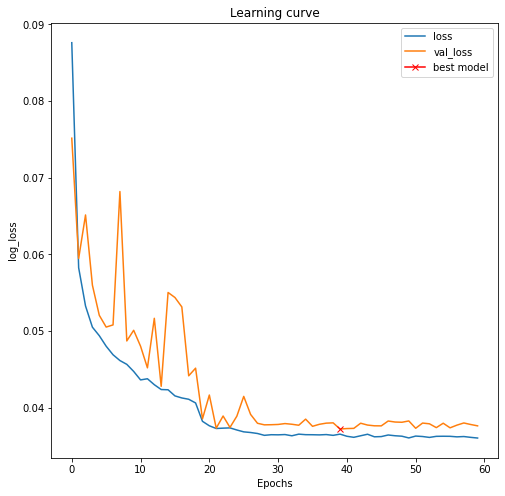

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.savefig("./unet_small_jaccard")
plt.legend();

# Model Evaluation

In [18]:
#load test data
oTestImgDir = "D:\PRS_project\Data_Set_HAM\segmentation_data_final\\test\\image\\"
oTestLblDir = "D:\PRS_project\Data_Set_HAM\segmentation_data_final\\test\\segmentation"
def load_data(oImgPath,oLblDir):
    x = []
    y = []
    for path in oImgPath:
        oFileName = path.split("\\")[-1]
        oFileName = oFileName.split(".")[0]
        oImage = cv2.imread(path)
        x.append(oImage)
        oLblPath = os.path.join(oLblDir,oFileName + ".png")
        oLabel = cv2.imread(oLblPath,0)/255
        y.append(oLabel)
    return np.array(x), np.array(y)
#load train data 
oTestImgPath = glob(oTestImgDir + "*.jpg")
XTest,YTest = load_data(oTestImgPath,oTestLblDir)

In [19]:

# load the best model after training for testing on test dataset

input_img_0 = Input((IMG_HEIGHT,IMG_WIDTH, 3), name='img')
model_0 = get_unet(input_img_0, n_filters=32, dropout=0.3, batchnorm=True)
model_0.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy",dice_coe,iou])
model_0.load_weights('model-skin-lesion-segmentation.hdf5')
#print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(XTest, YTest, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[2]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[3]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')



56/56 [==============================] - 5s 62ms/step - loss: 0.1236 - accuracy: 0.1181 - dice_coe: 0.9003 - iou: 0.9603
________________________
IOU:       |   90.03  |
Dice Coef: |   96.03  |
Loss:      |   12.36  |
________________________


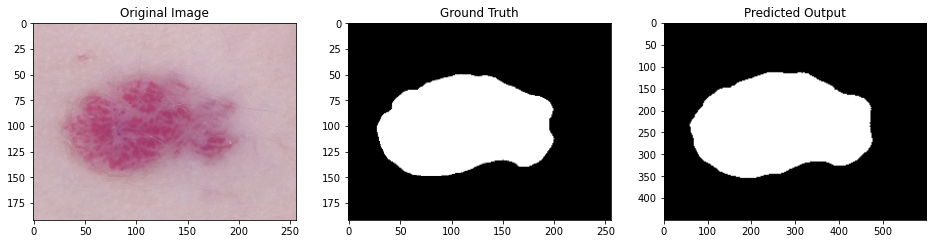

In [55]:

def enhance(img):
    sub = (model_0.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub
img_num = 267
img_pred = model_0.predict(XTest[img_num].reshape(1,IMG_HEIGHT,IMG_WIDTH,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
oImage = cv2.cvtColor(XTest[img_num], cv2.COLOR_BGR2RGB)
plt.imshow(oImage)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(YTest[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
img_pred = enhance(XTest[img_num])
img_pred = img_pred.reshape(IMG_HEIGHT,IMG_WIDTH)
img_pred = cv2.resize(img_pred, (600,450), interpolation = cv2.INTER_AREA)
plt.imshow(img_pred, plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

In [ ]:
oEnlarge 